### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid



device = torch.device("cuda")

In [2]:
!mkdir celeba

In [5]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:


#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)



0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Files already downloaded and verified


In [11]:
IMG_SHAPE = tuple(train_dataset[0][0].shape)

### Prepare Dataset

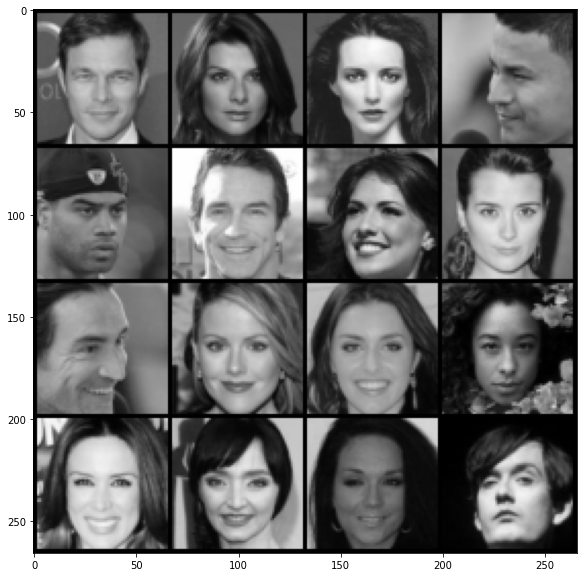

In [7]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [8]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [124]:
#!L
CODE_SIZE = 100 # Size of z noise vector; feel free to change it


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # TODO

        self.generator = nn.Sequential(
            nn.Linear(CODE_SIZE, 16*8*8),
            nn.ELU(),
            Reshape([-1, 16, 8, 8]),

            nn.ConvTranspose2d(16, 4, kernel_size=(4,4), stride=4),
            nn.ELU(),

            nn.ConvTranspose2d(4, 1, kernel_size=(2,2), stride=2),
            nn.Tanh()

        )


    def forward(self, noise):
        return (1 + self.generator(noise)) / 2

generator = Generator().to(device)

In [125]:
noise = sample_noise_batch(5)
noise.shape

torch.Size([5, 100])

In [126]:
#!L
generated_data = generator(noise)
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [127]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [128]:
#!L
discriminator = nn.Sequential()

## YOUR CODE - create convolutional architecture for discriminator
## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

#!L
discriminator = nn.Sequential()

# reshape from "images" to flat vectors


discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same'))
discriminator.add_module('conv1_elu', nn.ELU())
discriminator.add_module('pool1', nn.AvgPool2d(2))

discriminator.add_module('conv2', nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding='same'))
discriminator.add_module('conv2_elu', nn.ELU())
discriminator.add_module('pool2', nn.AvgPool2d(2))

discriminator.add_module('conv3', nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding='same'))
discriminator.add_module('conv3_elu', nn.ELU())
discriminator.add_module('pool3', nn.AvgPool2d(2))


discriminator.add_module('flatten', nn.Flatten())
# dense "head"
discriminator.add_module('dense1', nn.Linear(64 * 8 * 8, 16))
discriminator.add_module('dense1_elu', nn.ELU())
discriminator.add_module('dense2_logits', nn.Linear(16, 1)) 



discriminator.to(device)

Sequential(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_elu): ELU(alpha=1.0)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_elu): ELU(alpha=1.0)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_elu): ELU(alpha=1.0)
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=4096, out_features=16, bias=True)
  (dense1_elu): ELU(alpha=1.0)
  (dense2_logits): Linear(in_features=16, out_features=1, bias=True)
)

In [129]:
#!L
images = sample_data_batch(4)

In [130]:
images[0]

tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.0118, 0.0118, 0.0157],
         [0.0078, 0.0078, 0.0039,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0078, 0.0039,  ..., 0.0078, 0.0118, 0.0078],
         ...,
         [0.8106, 0.8083, 0.8239,  ..., 0.5048, 0.3911, 0.2509],
         [0.8235, 0.8219, 0.8337,  ..., 0.7348, 0.6984, 0.6765],
         [0.8164, 0.8164, 0.8282,  ..., 0.8029, 0.7485, 0.7053]]],
       device='cuda:0')

In [131]:
predictions = discriminator(images)

In [132]:
predictions.shape

torch.Size([4, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [133]:
#!L
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    assert torch.isnan(logp_gen_is_real).sum() == 0
    loss = -logp_gen_is_real.sum()
    
    return loss

In [134]:
#!L
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(20.3425, device='cuda:0', grad_fn=<NegBackward0>)


In [135]:
#!L
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = torch.log(1 - torch.sigmoid(disc_on_fake_data))
    assert torch.isnan(logp_real_is_real).sum() == 0
    assert torch.isnan(logp_gen_is_fake).sum() == 0

    loss = logp_real_is_real.sum() + logp_gen_is_fake.sum()
    return loss

In [136]:
#!L
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(-44.4485, device='cuda:0', grad_fn=<AddBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [137]:
#!L
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.squeeze().data.cpu().numpy()
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

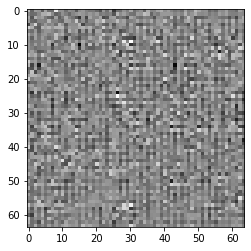

In [138]:
images = generator(sample_noise_batch(batch_size=1))
images = images.squeeze().data.cpu().numpy()
plt.imshow(images, cmap="gray", interpolation="none")

In [139]:

for name, param in discriminator.named_parameters():
    print("{} size {}  nans {} infs {}".format(name, param.size(), torch.isnan(param).sum(), torch.isinf(param).sum()))

conv1.weight size torch.Size([4, 1, 3, 3])  nans 0 infs 0
conv1.bias size torch.Size([4])  nans 0 infs 0
conv2.weight size torch.Size([16, 4, 3, 3])  nans 0 infs 0
conv2.bias size torch.Size([16])  nans 0 infs 0
conv3.weight size torch.Size([64, 16, 3, 3])  nans 0 infs 0
conv3.bias size torch.Size([64])  nans 0 infs 0
dense1.weight size torch.Size([16, 4096])  nans 0 infs 0
dense1.bias size torch.Size([16])  nans 0 infs 0
dense2_logits.weight size torch.Size([1, 16])  nans 0 infs 0
dense2_logits.bias size torch.Size([1])  nans 0 infs 0


In [140]:
class Functor(object):
    def __init__(self, prev):
        assert torch.isnan(prev).sum() == 0
        assert torch.isinf(prev).sum() == 0
        self.prev = prev

    def __call__(self, module):
        new_prev = module(self.prev)
        assert torch.isnan(new_prev).sum() == 0, "name = {}".format(module)
        assert torch.isinf(new_prev).sum() == 0, "name = {}".format(module)
        self.prev = new_prev

In [141]:
func = Functor(real_data[0:1])
discriminator.apply(func)

RuntimeError: ignored

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [142]:
#!L
# optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

epoch 0
iteration 0 out of 1627


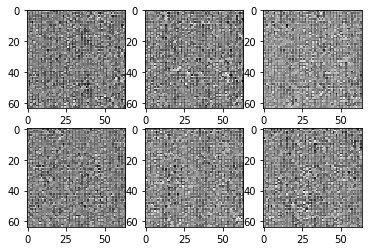

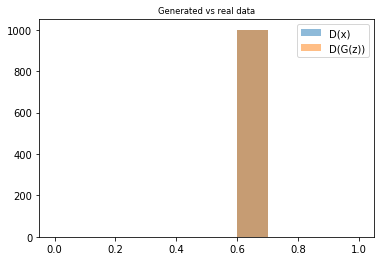

AssertionError: ignored

In [143]:
#!L
from IPython import display
from tqdm.auto import tqdm

clip = 30

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(25):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        real_data = batch.to(device)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), clip)
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(generator.parameters(), clip)
            gen_opt.step()

        if iteration % 100 == 0:
            display.clear_output(wait=True)
            print("epoch {}".format(epoch))
            print("iteration {} out of {}".format(iteration, len(train_dataset) // batch_size))
            sample_images(2,3,True)
            sample_probas(1000)
        

In [ ]:
#!L
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please generate the same number of images as for autoencoders for a fair comparison.

In [ ]:
#!L
num_images = 10000
batch_size = 100

all_images = []

for batch_i in range(int((num_images - 1) / batch_size + 1)):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)